In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.io.sql as sqlio
import psycopg2 as ps

In [3]:
conn = ps.connect(dbname="bitirme",
                  user="postgres",
                  password="12345",
                  port = "5432")

# ---------------------------------------------------------------------------------------------------------

# CASE-1: Satış Ekibi İçin Analiz

### A
- Satış Ekibi, her bir ürün kategorisinde satışlardan elde edilen toplam gelir, ortalama sipariş değeri ve toplam satılan ürün miktarının analiz edilmesini istemiştir.
- En yüksek satış geliri olan kategorilerin tespiti istenmiştir.

### B
- Kategori başına toplam satış ve ortalama sipariş değerlerinin birbiri ile olan ilişkisinin görsel üzerinde incelenmesi istenmiştir.

### C
- Kategorilerin toplam gelire göre katkısının yüzde olarak görselleştirilmesi istenmiştir.

### D
- Kategoriye göre toplam gelir ve satılan ürün miktarının beraber incelenmesi ve görselleştirilmesi istenmiştir.


### Açıklama:Bu sql sorgusu ile her bir ürün kategorisinde satışlardan elde edilen toplam gelir,ortalama sipariş değeri  ve toplam satılan ürün miktarını analiz edilmiştir

In [5]:
sql="""  WITH category_sales AS (
    SELECT 
        p.category_id,
        cat.category_name,
        od.product_id,
        SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_revenue,
        SUM(od.quantity) AS total_quantity_sold
    FROM 
        order_details AS od  ----
    JOIN 
        products AS p ON od.product_id = p.product_id
    JOIN 
        categories AS cat ON p.category_id = cat.category_id
    GROUP BY 
        p.category_id, cat.category_name, od.product_id
)

SELECT 
    category_name,
    round(SUM(total_revenue)::numeric,1) AS category_total_revenue,
    round(AVG(total_revenue)::numeric,1) AS avg_order_value,
    round(SUM(total_quantity_sold)::numeric,1) AS category_total_quantity_sold
FROM 
    category_sales
GROUP BY 
    category_name
ORDER BY 
    category_total_revenue DESC;"""

In [7]:
df = sqlio.read_sql_query(sql,conn)
df.head()

C:\Users\Tayfun\AppData\Local\Temp\ipykernel_38984\1600180838.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


,category_name,category_total_revenue,avg_order_value,category_total_quantity_sold
0,Beverages,267868.2,22322.3,9532.0
1,Dairy Products,234507.3,23450.7,9149.0
2,Confections,167357.2,12873.6,7906.0
3,Meat/Poultry,163022.4,27170.4,4199.0
4,Seafood,131261.7,10938.5,7681.0


In [11]:
# Sorguyu çalıştırma ve sonuçları pandas DataFrame’e aktarma
df = pd.read_sql(sql, conn)



C:\Users\Tayfun\AppData\Local\Temp\ipykernel_5084\3359622886.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


# A- En yüksek satış geliri olan kategorilerin incelenmesi

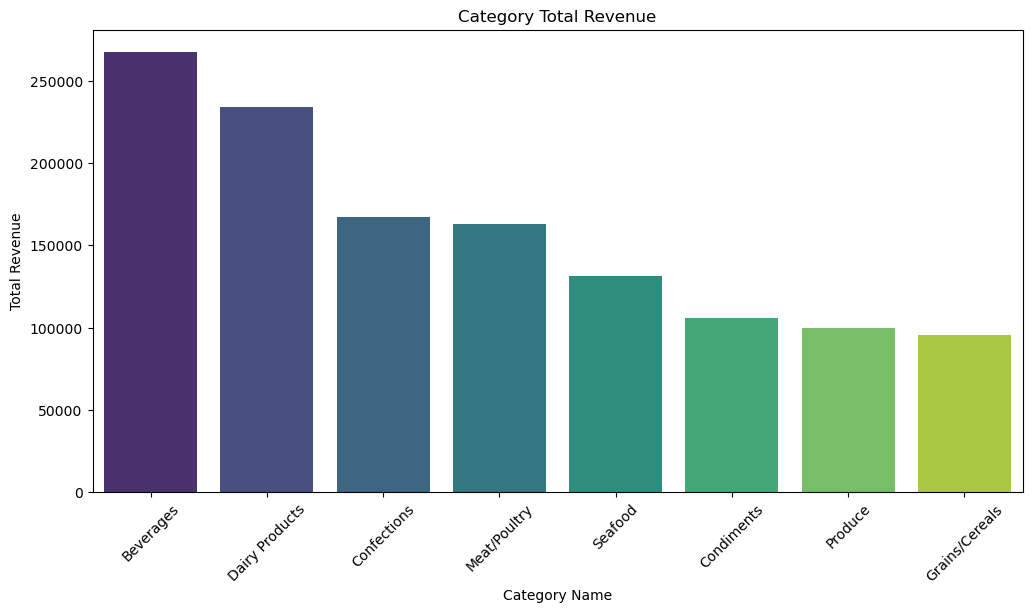

In [12]:
# Çubuk grafik ile kategori başına toplam gelir
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="category_name", y="category_total_revenue", palette="viridis")
plt.title("Category Total Revenue")
plt.xlabel("Category Name")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()


### Sonuç:En yüksek satış gelirine sahip kategoriler Beverages Dairy Products Cenfections olarak tespit edilmiştir.Grains/Cereals ve Produce kategorilerinin gelişimi için çalışma yapılmalıdır

# B-Kategori başına toplam satış ve ortalama sipariş değerlerinin incelenmesi

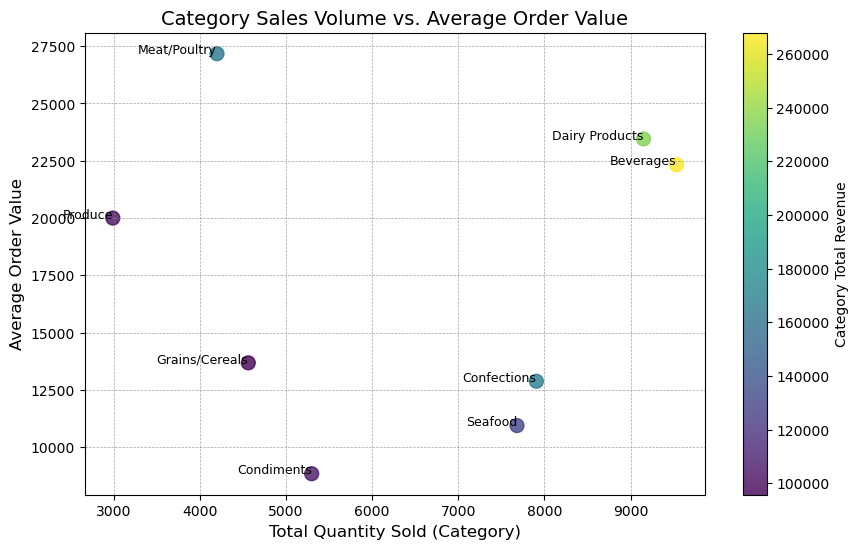

In [8]:


# Dağılım grafiği: kategori başına toplam satış miktarı ve ortalama sipariş değerini analiz etme
plt.figure(figsize=(10, 6))
plt.scatter(
    data=df, 
    x="category_total_quantity_sold", 
    y="avg_order_value", 
    s=100, 
    alpha=0.8, 
    c="category_total_revenue", 
    cmap="viridis"  
)
plt.colorbar(label="Category Total Revenue")
plt.title("Category Sales Volume vs. Average Order Value", fontsize=14)
plt.xlabel("Total Quantity Sold (Category)", fontsize=12)
plt.ylabel("Average Order Value", fontsize=12)

# Her noktanın üzerine kategori ismini yazalım
for i in range(len(df)):
    plt.text(
        df["category_total_quantity_sold"][i], 
        df["avg_order_value"][i], 
        df["category_name"][i], 
        fontsize=9, 
        ha='right'
    )

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Daha belirgin bir ızgara ekledik
plt.show()


### Sonuç: Tablo incelendiğinde Dairy products ve Beverages kategorilerinin yüksek satış ve yüksek ortalama sipariş değerine sahip olduğu görülüyor.Confections ve seafood kategorilerinin yüksek satış rakamları olmasına rağmen ortalma sipariş değerlerinin düşük oldugu görülüyor.Bu iki kategorinin ortalama sipariş değerlerini nasıl arttırabiliriz araştırma yapılmalıdır.Meat/Poultry kagetorisinin ortalama sipariş değerinin yüksek olduğu ama satış adetinin düşük olduğu görülüyor.Sipariş sayılarının nasıl arttırılacağı gerekirse fiyat araştırması yapılmasının faydalı olacağı değerlendirildi.

# C- Kategorilerin toplam gelire katkısının incelenmesi

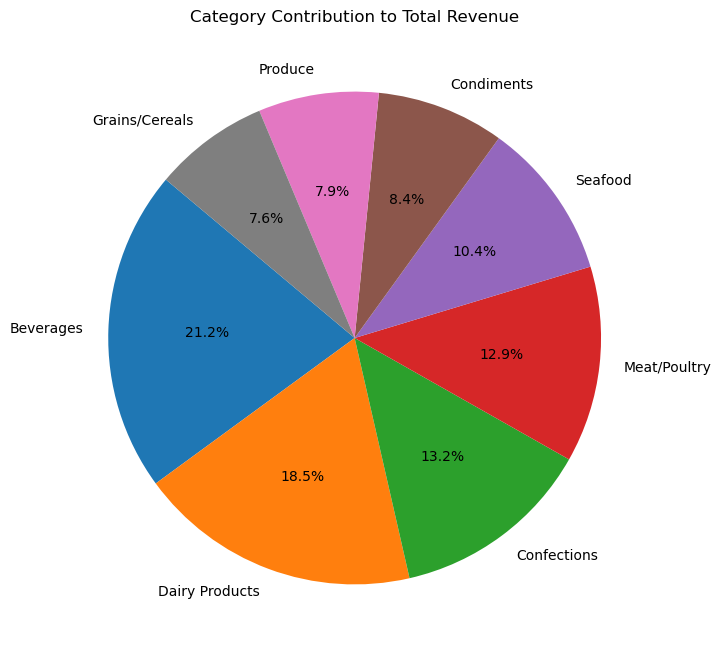

In [33]:

plt.figure(figsize=(8, 8))
plt.pie(df["category_total_revenue"], labels=df["category_name"], autopct='%1.1f%%', startangle=140)
plt.title("Category Contribution to Total Revenue")
plt.show()


### Sonuç:
### -Produce ve Grain/Cereals kategorilerinin performansını arttırmak için çalışmalıyız.Satış gelirlerinin toplam gelire göre düşük olduğu görülüyor.
### -Beverages,Dairy Products ve Confections kategorileri en çok gelir sağlayan kategorilerdir.Bu kategorilerin performansına dikkat edilmelidir.Bu kategorilerdeki performans düşüklüğü şirketin genel gelirini olumsuz etkiler

# D- Kategoriye göre toplam gelir ve satılan ürün miktarı

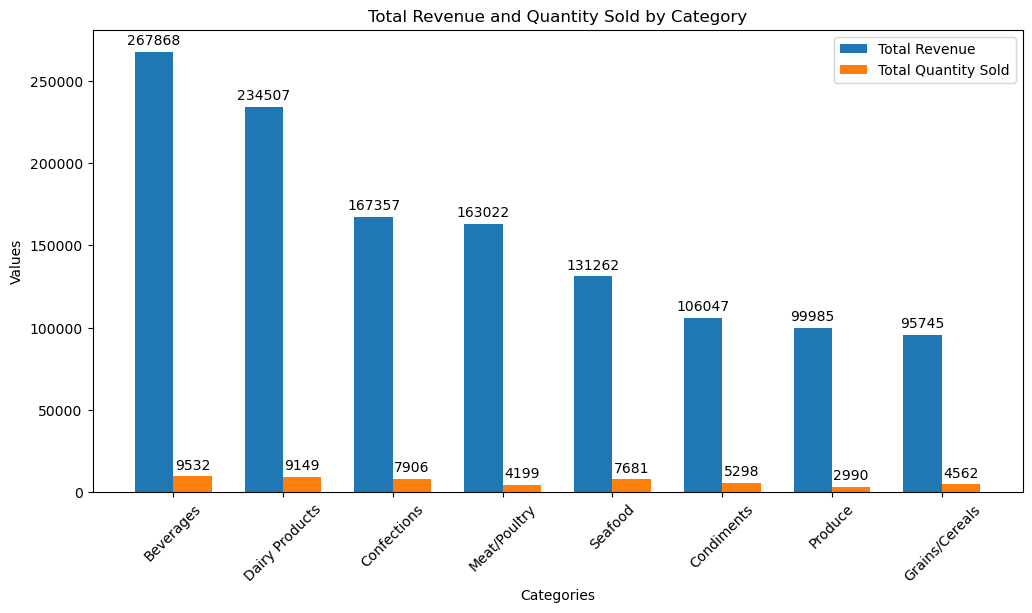

In [36]:


# Çubuk grafiği oluşturmak için gerekli verileri yazalım
categories = df["category_name"]
revenue = df["category_total_revenue"]
quantity_sold = df["category_total_quantity_sold"]

# Grafik ayarlarının yapılması 
x = np.arange(len(categories))  # Kategori sayısı kadar konum oluşturma
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, revenue, width, label='Total Revenue')
bar2 = ax.bar(x + width/2, quantity_sold, width, label='Total Quantity Sold')

# Grafik başlığı ve etiketlerin oluşturulması
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Total Revenue and Quantity Sold by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

# Çubukların üzerine değerleri yazalım
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',  # Sayıyı formatlayarak yazdırma
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.show()


### Sonuç: Yüksek satış hacmine rağmen düşük gelir elde eden seafood ve produce kategorileri için fiyat stratejileri tekrar gözden geçirilmelidir.Grains/Cereals kategorisinin gelir miktar performans oranı bir çok kategoriye göre iyi görünüyor.Performansın düşmemesine dikkat edilmesi gerekir.

# ------------------------------------------------------------------------------------------------------------

# CASE-2: Lojistik Ekibi İçin Analizler

### Analiz Başlıkları:
- **Lojistik ekibi nakliye firmalarının ortalama nakliye süresi (sipariş tarihi ile teslimat tarihi arasındaki gün farkı) analiz ederek en uzun nakliye sürelerine sahip nakliyecileri belirlememizi istiyor.**
- **Ortalama nakliye süresi, maksimum nakliye süresi ve minimum nakliye sürelerini inceleyip görselleştirmemizi istiyor.**


In [4]:
sql2="""WITH shipping_times AS (
    SELECT 
        o.order_id,
        o.ship_via,
        s.company_name AS shipper_name,
        (o.shipped_date - o.order_date) AS shipping_duration
    FROM 
        Orders AS o
    JOIN 
        Shippers AS s ON o.ship_via = s.shipper_id
    WHERE 
        o.shipped_date IS NOT NULL
)

SELECT 
    shipper_name,
    round(AVG(shipping_duration),2) AS avg_shipping_duration,
    round(MAX(shipping_duration)) AS max_shipping_duration,
    round(MIN(shipping_duration)) AS min_shipping_duration,
    COUNT(order_id) AS total_orders
FROM 
    shipping_times
GROUP BY 
    shipper_name
ORDER BY 
    avg_shipping_duration DESC """

In [5]:
df2 = sqlio.read_sql_query(sql2,conn)
df2

C:\Users\Tayfun\AppData\Local\Temp\ipykernel_22728\4280454062.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = sqlio.read_sql_query(sql2,conn)


,shipper_name,avg_shipping_duration,max_shipping_duration,min_shipping_duration,total_orders
0,United Package,9.23,37.0,1.0,315
1,Speedy Express,8.57,37.0,1.0,245
2,Federal Shipping,7.47,35.0,1.0,249


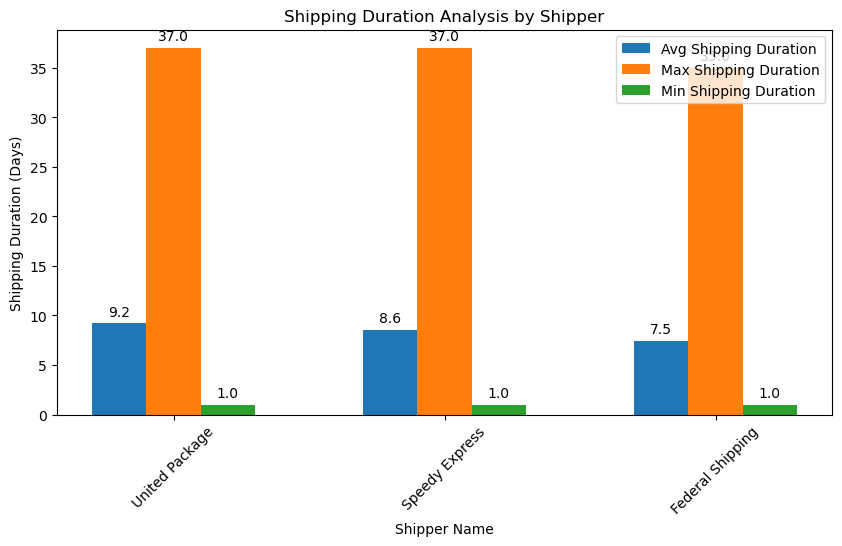

In [15]:


x = np.arange(len(df2["shipper_name"]))  # Nakliyeci isimleri için konumlama satırı
width = 0.2  


fig, ax = plt.subplots(figsize=(10, 5))
bar1 = ax.bar(x - width, df2["avg_shipping_duration"], width, label='Avg Shipping Duration')
bar2 = ax.bar(x, df2["max_shipping_duration"], width, label='Max Shipping Duration')
bar3 = ax.bar(x + width, df2["min_shipping_duration"], width, label='Min Shipping Duration')


ax.set_xlabel("Shipper Name")
ax.set_ylabel("Shipping Duration (Days)")
ax.set_title("Shipping Duration Analysis by Shipper")
ax.set_xticks(x)
ax.set_xticklabels(df2["shipper_name"], rotation=45)
ax.legend()

# Çubukların üstüne değerleri ekliyoruz
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.show()


### Sonuç:United package firmasının ortalama teslim süresi en yüksek görünüyor.En iyi ortalama teslim süresi Federal Shipping firması olarak görünüyor.Özellikle United package firmasının teslim sürelerinin neden uzun olduğu araştırılmalıdır.

# ---------------------------------------------------------------------------------------------------

# CASE-3: İnsan Kaynakları İçin Analiz

### Analiz Başlıkları:
- **Görevi Sales Representative unvanına sahip çalışanların performanslarını analiz edebileceğimiz bir görsel isteniyor.**
- **Performansları Yüksek, Orta ve Düşük olarak sınıflandırmamız istendi.**
- **Performans metriği olarak şirket ortalamasının %20 üzerinde olanları Yüksek performans, şirket ortalamasının %20 altında olanları Düşük performans bunun dışındakileri Orta performans olarak ayırmamız istendi.**


In [21]:
sql3="""WITH monthly_sales AS (
    SELECT 
        e.employee_id,
        e.first_name || ' ' || e.last_name AS employee_name,
        DATE_TRUNC('month', o.order_date) AS sales_month,
        SUM(od.unit_price * od.quantity * (1 - od.discount)) AS monthly_sales_amount
    FROM 
        employees AS e
    LEFT JOIN 
        orders AS o ON e.employee_id = o.employee_id
    LEFT JOIN 
        order_details AS od ON o.order_id = od.order_id
    WHERE 
        e.title = 'Sales Representative'  -- Yalnızca "Sales Representative" olanlar seçildi
    GROUP BY 
        e.employee_id, sales_month
),
employee_performance AS (
    SELECT 
        employee_id,
        employee_name,
        AVG(monthly_sales_amount) AS avg_monthly_sales
    FROM 
        monthly_sales
    GROUP BY 
        employee_id, employee_name
),
company_performance AS (
    SELECT 
        AVG(avg_monthly_sales) AS company_avg_sales
    FROM 
        employee_performance
)

SELECT 
    ep.employee_id,
    ep.employee_name,
    ep.avg_monthly_sales,
    cp.company_avg_sales,
    CASE
        WHEN ep.avg_monthly_sales >= cp.company_avg_sales * 1.2 THEN 'Yüksek Performans'
        WHEN ep.avg_monthly_sales >= cp.company_avg_sales * 0.8 AND ep.avg_monthly_sales < cp.company_avg_sales * 1.2 THEN 'Orta Performans'
        ELSE 'Düşük Performans'
    END AS performance_class
FROM 
    employee_performance AS ep
CROSS JOIN 
    company_performance AS cp
ORDER BY 
    ep.avg_monthly_sales DESC;
"""

In [22]:
df3 = sqlio.read_sql_query(sql3,conn)
df3.head()

C:\Users\Tayfun\AppData\Local\Temp\ipykernel_5084\958191848.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = sqlio.read_sql_query(sql3,conn)


,employee_id,employee_name,avg_monthly_sales,company_avg_sales,performance_class
0,4,Margaret Peacock,10125.688956,6907.224195,Yüksek Performans
1,3,Janet Leverling,9218.765563,6907.224195,Yüksek Performans
2,1,Nancy Davolio,8352.504550,6907.224195,Yüksek Performans
3,7,Robert King,5931.820707,6907.224195,Orta Performans
4,9,Anne Dodsworth,4294.892569,6907.224195,Düşük Performans


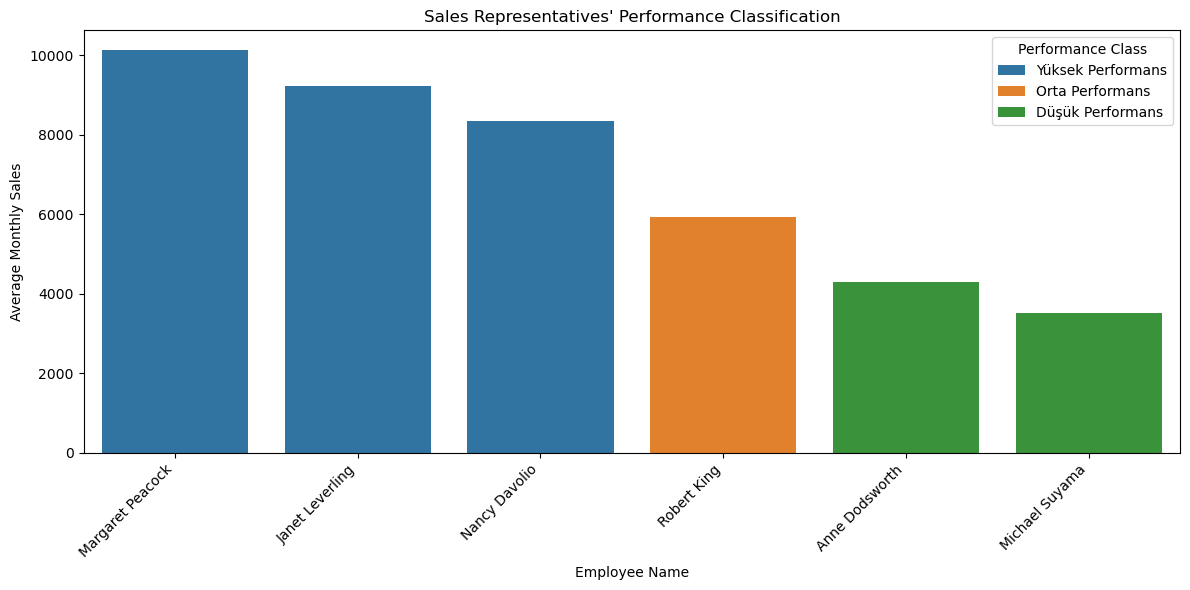

In [23]:

plt.figure(figsize=(12, 6))

sns.barplot(data=df3, x="employee_name", y="avg_monthly_sales", hue="performance_class", dodge=False)

plt.title("Sales Representatives' Performance Classification")
plt.xlabel("Employee Name")
plt.ylabel("Average Monthly Sales")
plt.xticks(rotation=45, ha='right')  # Çalışan isimlerini döndürme
plt.legend(title="Performance Class")


plt.tight_layout()
plt.show()


### Sonuç:Bu sorgu  satış temsilcilerinin aylık ortalma satışlarını sınıflandırıyor.Buna göre şirket ortalamasının % 20 üzerinde olanlar yüksek performans göstermekte %20 altında olanlar ise düşük performans sergilemektedir.Bu sorgumuzun sonucuna göre Anne Dodsworth ve Michael Suyama adlı çalışanların satış performanları düşük görülmektedir.Bu çalışanların şirket içi eğitime tabi tutulmaları faydalı olacaktır.Yüksek performans gösteren Margaret Peacock,Janet Leverling ve Nancy Davolio için performans primi önerildi.

# ---------------------------------------------------------------------------------------------------------------

# CASE-4: SATINALMA TEDARİKÇİ ANALİZİ İSTİYOR

## Analiz Başlıkları:
1. **Satışa en çok katkı sağlayan tedarikçilerin belirlenmesi**:
   - Tedarikçilerin toplam satışlara olan katkısının analiz edilmesi.

2. **Tedarikçilerin sağladığı ürün çeşitliliğinin satışlara etkisinin analiz edilmesi**:
   - Sağlanan ürün çeşitliliği ve toplam satış arasındaki ilişkinin değerlendirilmesi.

3. **Toplam ürün miktarı ve sipariş ilişkisinin araştırılması**:
   - En fazla ürün sağlayan tedarikçilerin belirlenmesi.
   - Bu tedarikçilerin ürünlerinin toplam siparişlerdeki rolünün analiz edilmesi.


In [9]:
sql4="""WITH supplier_analysis AS (
    SELECT 
        s.supplier_id,
        s.company_name AS supplier_name,                     -- Tedarikçi adı
        COUNT(DISTINCT p.product_id) AS product_count,       -- Tedarikçinin sağladığı toplam ürün sayısı
        COUNT(DISTINCT od.order_id) AS total_orders,         -- Tedarikçinin ürünlerinin bulunduğu toplam sipariş sayısı
        SUM(od.quantity) AS total_quantity,                 -- Tedarikçinin sağladığı toplam ürün miktarı
        ROUND(SUM(od.unit_price * od.quantity * (1 - od.discount))::numeric, 2) AS total_sales -- Tedarikçiden sağlanan toplam gelir
    FROM 
        suppliers AS s
    JOIN 
        products AS p ON s.supplier_id = p.supplier_id
    JOIN 
        order_details AS od ON p.product_id = od.product_id
    GROUP BY 
        s.supplier_id, s.company_name
)

SELECT 
    supplier_id,
    supplier_name,
    product_count,
    total_orders,
    total_quantity,
    total_sales,
    ROUND((total_sales / SUM(total_sales) OVER()) * 100, 2) AS sales_contribution_percentage -- Toplam satışa katkı yüzdesi
FROM 
    supplier_analysis
ORDER BY 
    total_sales DESC;
"""

In [10]:
df4 = sqlio.read_sql_query(sql4,conn)
df4.head()

C:\Users\Tayfun\AppData\Local\Temp\ipykernel_14416\1053938286.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = sqlio.read_sql_query(sql4,conn)


,supplier_id,supplier_name,product_count,total_orders,total_quantity,total_sales,sales_contribution_percentage
0,18,Aux joyeux ecclésiastiques,2,53,1416,153691.28,12.14
1,12,Plutzer Lebensmittelgroßmärkte AG,5,161,4072,145372.40,11.48
2,28,Gai pâturage,2,104,3073,117981.18,9.32
3,7,"Pavlova, Ltd.",5,153,3937,106459.78,8.41
4,24,"G'day, Mate",3,95,2108,65626.77,5.18


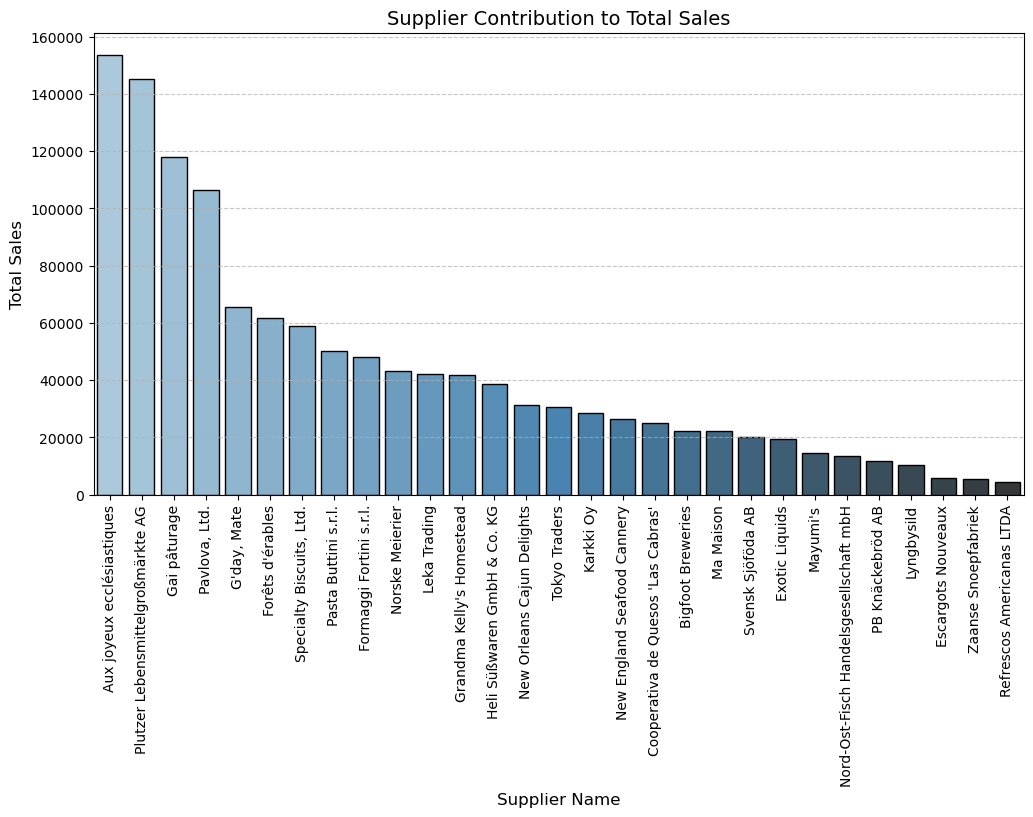

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x="supplier_name", 
    y="total_sales", 
    data=df4, 
    palette="Blues_d", 
    edgecolor="black"
)
plt.title("Supplier Contribution to Total Sales", fontsize=14)
plt.xlabel("Supplier Name", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=90)

plt.show()


### Yorum:Özellikle ilk 4 tedarikçinin satışa katkısının çok büyük olduğu dikkat çekiyor.Bu tedarikçiler ile işbirliğinin arttırılması satışlara katkı sağlayacaktır.

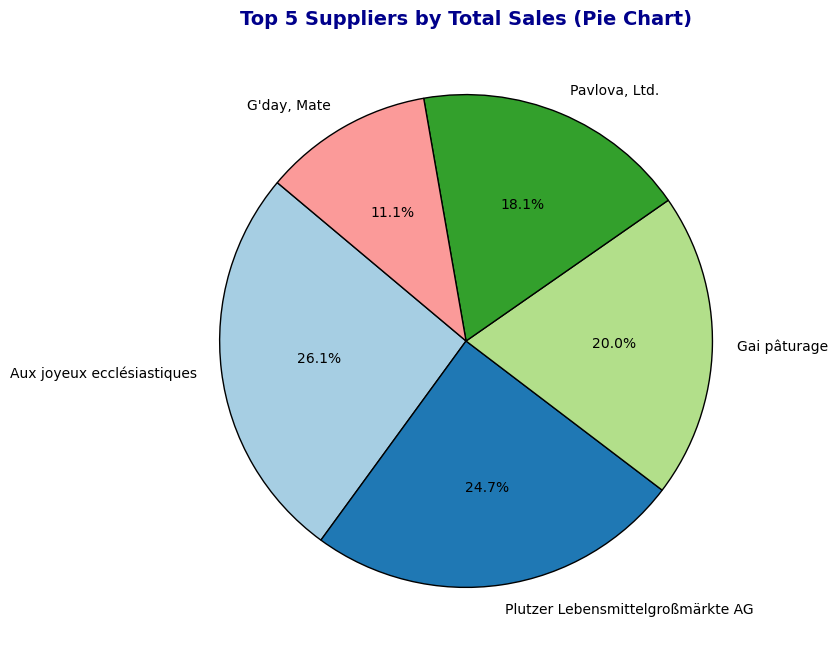

In [21]:
# İlk 5 tedarikçiyi seç
top_5_suppliers = df4.nlargest(5, "total_sales")

# Pasta grafiği: En çok satış yapan ilk 5 tedarikçi
plt.figure(figsize=(10, 8))
plt.pie(
    top_5_suppliers["total_sales"], 
    labels=top_5_suppliers["supplier_name"], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired(range(len(top_5_suppliers))),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Top 5 Suppliers by Total Sales (Pie Chart)", fontsize=14, fontweight='bold', color="darkblue")
plt.show()


# -------------------------------------------------------------------------------------------------------

# CASE 5: Pazarlama Departmanı - Ülke Analizi

## Analiz Başlıkları:
1. **Ülke Adı**:
   - Siparişlerin hangi ülkelerden geldiğini belirtir.

2. **Toplam Sipariş**:
   - Her ülkenin oluşturduğu toplam sipariş sayısını gösterir.

3. **Toplam Satış**:
   - Her ülkenin oluşturduğu toplam satış değerini ifade eder.

4. **Ortalama Satış Değeri**:
   - Her ülkedeki siparişlerin ortalama değerini hesaplar.

5. **Ülkelerin Toplam Satış Değeri İçindeki Yüzdesel Katkısı**:
   - Her ülkenin toplam satışa olan yüzdesel katkısını ifade eder.


  

In [17]:
sql5="""WITH country_analysis AS (
    SELECT 
        c.country AS customer_country,                          -- Müşteri ülkesi
        COUNT(DISTINCT o.order_id) AS total_orders,             -- Toplam sipariş sayısı
        ROUND(SUM(od.unit_price * od.quantity * (1 - od.discount))::numeric, 2) AS total_sales,  -- Toplam satış tutarı
        ROUND(AVG(od.unit_price * od.quantity * (1 - od.discount))::numeric, 2) AS avg_order_value -- Ortalama sipariş değeri
    FROM 
        customers AS c
    JOIN 
        orders AS o ON c.customer_id = o.customer_id
    JOIN 
        order_details AS od ON o.order_id = od.order_id
    GROUP BY 
        c.country
    ORDER BY 
        total_sales DESC
)

SELECT 
    customer_country,
    total_orders,
    total_sales,
    avg_order_value,
    ROUND((total_sales / SUM(total_sales) OVER()) * 100, 2) AS sales_contribution_percentage -- Toplam satışa katkı yüzdesi
FROM 
    country_analysis
ORDER BY 
    total_sales DESC;
"""

In [18]:
df5 = sqlio.read_sql_query(sql5,conn)
df5.head()

C:\Users\Tayfun\AppData\Local\Temp\ipykernel_22728\3473480067.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = sqlio.read_sql_query(sql5,conn)


,customer_country,total_orders,total_sales,avg_order_value,sales_contribution_percentage
0,USA,122,245584.61,697.68,19.40
1,Germany,122,230284.63,702.09,18.19
2,Austria,40,128003.84,1024.03,10.11
3,Brazil,83,106925.78,526.73,8.45
4,France,77,81358.32,442.16,6.43


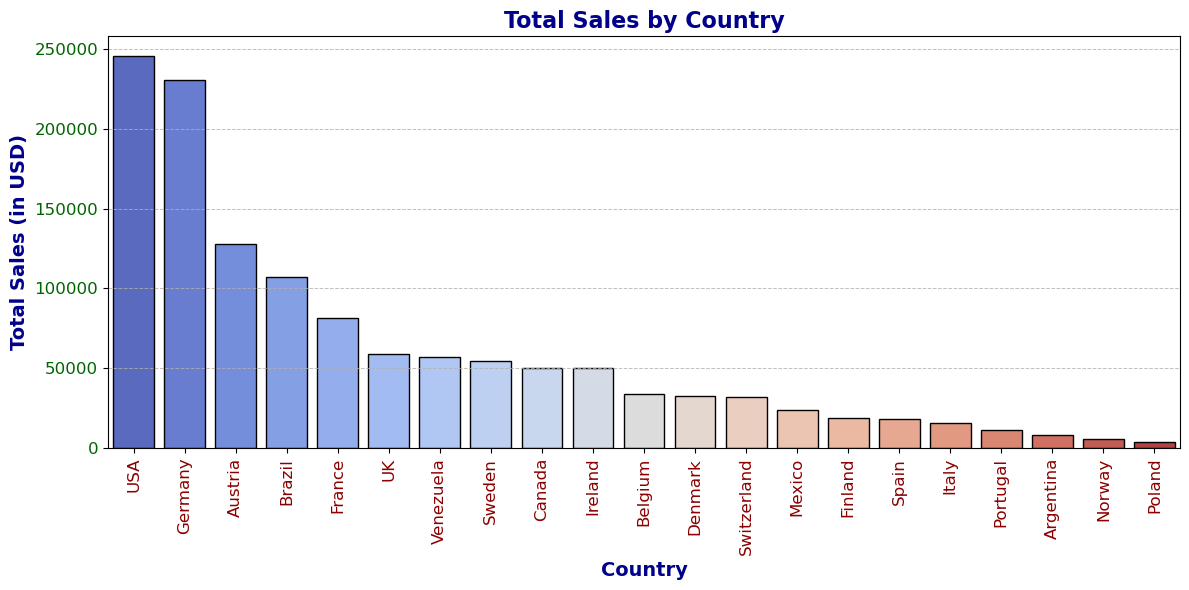

In [19]:


# Bar grafiği: Ülkelere göre toplam satışlar
plt.figure(figsize=(12, 6))
sns.barplot(
    x="customer_country", 
    y="total_sales", 
    data=df5, 
    palette="coolwarm", 
    edgecolor="black"
)

# Başlık ve etiketler
plt.title("Total Sales by Country", fontsize=16, fontweight='bold', color="darkblue")
plt.xlabel("Country", fontsize=14, fontweight='bold', color="darkblue")
plt.ylabel("Total Sales (in USD)", fontsize=14, fontweight='bold', color="darkblue")

# X eksenindeki etiketleri düzenleme
plt.xticks(rotation=90, fontsize=12, color="darkred")
plt.yticks(fontsize=12, color="darkgreen")

# Y ekseni ızgara çizgileri
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.8)

plt.tight_layout()
plt.show()


### Yorum: En çok satış yapılan ilk 3 ülkenin Usa,Germany,Austria olduğu görülmektedir.Poland,Norway,Argentina pazarlarında satışın çok düşük olduğu görülmektedir.Ağırlık olarak avrupa kıtasındaki satışların artması için çalışma yapılmalıdır.

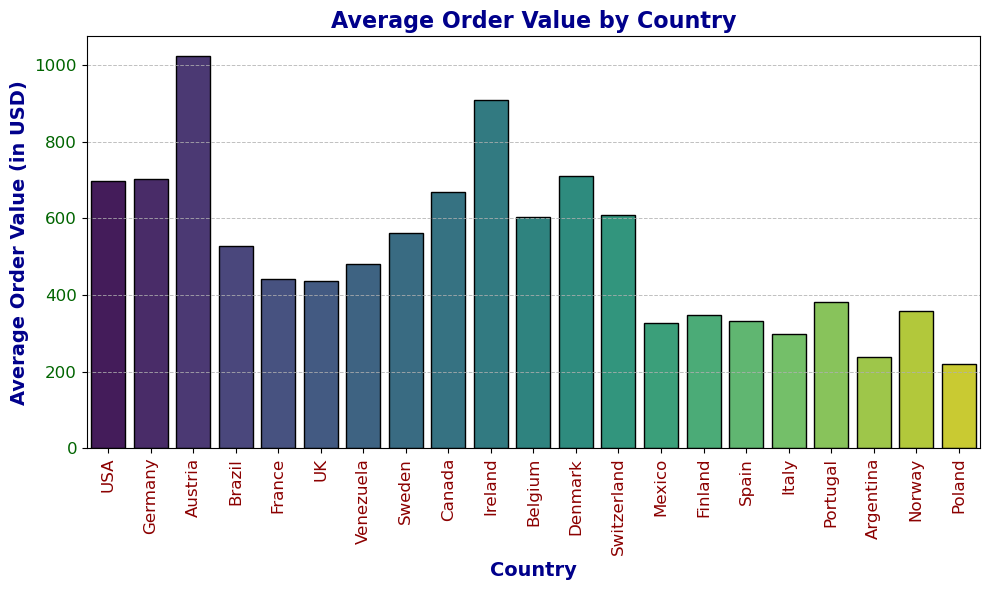

In [20]:
# Bar grafiği: Ülkelere göre ortalama satışlar
plt.figure(figsize=(10, 6))
sns.barplot(
    x="customer_country", 
    y="avg_order_value",  # Ortalama satışlar için sütun adı değiştirildi
    data=df5, 
    palette="viridis",  # Renk paleti güncellendi
    edgecolor="black"
)

# Başlık ve etiketler
plt.title("Average Order Value by Country", fontsize=16, fontweight='bold', color="darkblue")
plt.xlabel("Country", fontsize=14, fontweight='bold', color="darkblue")
plt.ylabel("Average Order Value (in USD)", fontsize=14, fontweight='bold', color="darkblue")

# X eksenindeki etiketleri düzenleme
plt.xticks(rotation=90, fontsize=12, color="darkred")
plt.yticks(fontsize=12, color="darkgreen")

# Y ekseni ızgara çizgileri
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.8)

plt.tight_layout()
plt.show()


###  Yorum:Austria nın hem satış gelirleri hemde sepet ortalamasında iyi olduğu görülmektedir.Usa ve Germany nin sepet ortalamasındaki çok küçük artışların gelire etkisi büyük olacaktır.